In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from gym.envs.toy_text import discrete

In [2]:
# Parameters
tam = 5
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [114]:
# Environment
class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, shape=[4, 4]):
        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape) # number of states
        nA = 4              # number of actions

        self.MAX_Y = shape[0]    # shape of the gridworld, x direction
        self.MAX_X = shape[1]    # shape of the gridworld, y direction

        P = {}              # dictionary of [states] [actions] = ([1.0, next_state, reward, is_done])
        self.grid = np.zeros(shape) - 1.0
        it = np.nditer(self.grid, flags=['multi_index']) # iteration over array 'grid'
        
        '''
        Numeration of the matrix 4x4 is as follows:
        0 1 2 3
        4 5 6 7
        8 9 10 11
        12 23 14 15
        '''

        while not it.finished:
            s = it.iterindex                    # states
            y, x = it.multi_index

            if s == 0 or s == (nS - 1):
                self.grid[y][x] = 0.0

            P[s] = {a : [] for a in range(nA)}  # dictionary with info of state, action and reward

            is_done = lambda s: s == 0 or s == (nS - 1) #can be modified to include more goals
            reward = 1.0 if is_done(s) else 0.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            #else:           #One may want to include some kind of list of goal states to substitute the next four lines.
            ns_up = s if y == 0 else s - self.MAX_X # move one full row to the left
            ns_right = s if x == (self.MAX_X - 1) else s + 1
            ns_down = s if y == (self.MAX_Y - 1) else s + self.MAX_X # move one full row to the right
            ns_left = s if x == 0 else s - 1
            P[s][UP] = [(1.0, ns_up, reward, False)]
            P[s][RIGHT] = [(1.0, ns_right, reward, False)]
            P[s][DOWN] = [(1.0, ns_down, reward, False)]
            P[s][LEFT] = [(1.0, ns_left, reward, False)]


            it.iternext()

        # Initial state distribution is uniform
        isd = np.zeros(nS)
        isd[nS//2] = 1
        # We expose the model of the environment for educational purposes
        # This should not be used in any model-free learning algorithm
        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        self.grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(self.grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip() 
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()

    def gen_features(self, state):

        y, x = np.unravel_index(state, self.shape)

        features = [np.linalg.norm([np.array((x, y)) - (0, 0)]),
                    np.linalg.norm((np.array((x, y)) - np.array((self.MAX_X, self.MAX_Y))))]
        return features

In [123]:
# Utilities
def trans_mat(env):
    return (np.array([[np.eye(1, env.nS, env.P[s][a][0][1])[0] for a in range(env.nA)] for s in range(env.nS)]),
            np.array([env.P[s][0][0][2] for s in range(env.nS)]))
        
def policy_iteration(trans_probs, reward, tam, gamma=0.9, epsilon=1e-3):
    n_states, n_actions, _ = trans_probs.shape
    PI1 = [0 for s in range(n_states)]
    R1 = reward
    deltas = []
    delta = 10000
    k = 0
    while delta >= epsilon:
        PI = PI1.copy()
        R = R1.copy()
        delta = 0
        P = np.zeros((n_states, n_states))
        for i in range(n_states):
            P[i] = trans_probs[i,PI[i]]
        M = (gamma*P)-np.eye(n_states)
        U = np.dot(np.linalg.inv(M),(-R))
        
        for i in range(n_states):
            maxU = -1000
            maxPI = 0
            maxR = 0
            for j in range(n_actions):
                if j == 0 and i >= tam:
                    r = R[i-tam]
                elif j == 1 and (i+1)%tam != 0:
                    r = R[i+1]
                elif j == 2 and i+tam < tam*tam:
                    r = R[i+tam]
                elif j == 3 and i%tam != 0:
                    r = R[i-1]
                else:
                    r = R[i]
                
                pa = gamma*np.dot(trans_probs[i,j],U)
                par = r + pa
                if maxU < par:
                    maxU = par
                    maxPI = j
                    maxR = r
            
            R1[i] = maxR
            PI1[i] = maxPI
            delta = max(delta, abs(PI1[i] - PI[i]))
        deltas.append(delta)
        print(k)
        k = k+1
        
    return PI1, deltas, U

def expected_utility(a, s, U, trans_probs):
    """The expected utility of doing a in state s, according to the MDP and U."""
    return sum([p * U[s1] for s1, p in enumerate(trans_probs[s, a, :])])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 0,

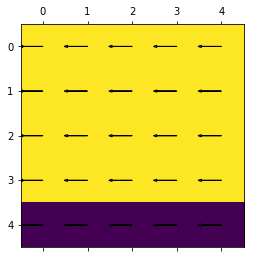

In [124]:
# Policy Iteration
if __name__ == '__main__':
    grid = GridworldEnv(shape=(tam,tam))
    trans_probs, reward = trans_mat(grid)
    PI, deltas, U = policy_iteration(trans_probs, reward, tam)
    #U = best_policy(trans_probs, PI)
    print(U)
    print(PI)

    def to_mat(u, shape):
        dst = np.zeros(shape)
        for k in range(len(u)):
            dst[k // shape[1], k % shape[1]] = u[k]
        return dst

    def add_arrow(pi, shape):
        for k in range(len(PI)):
            if PI[k] == UP:
                plt.arrow(k // shape[1], k % shape[1], -0.45, 0, head_width=0.05)
            elif PI[k] == RIGHT:
                plt.arrow(k // shape[1], k % shape[1], 0, 0.45, head_width=0.05)
            elif PI[k] == DOWN:
                plt.arrow(k // shape[1], k % shape[1], 0.45, 0, head_width=0.05)
            elif PI[k] == LEFT:
                plt.arrow(k // shape[1], k % shape[1], 0, -0.45, head_width=0.05)

    plt.matshow(to_mat(U, grid.shape))
    add_arrow(PI, grid.shape)
plt.show()

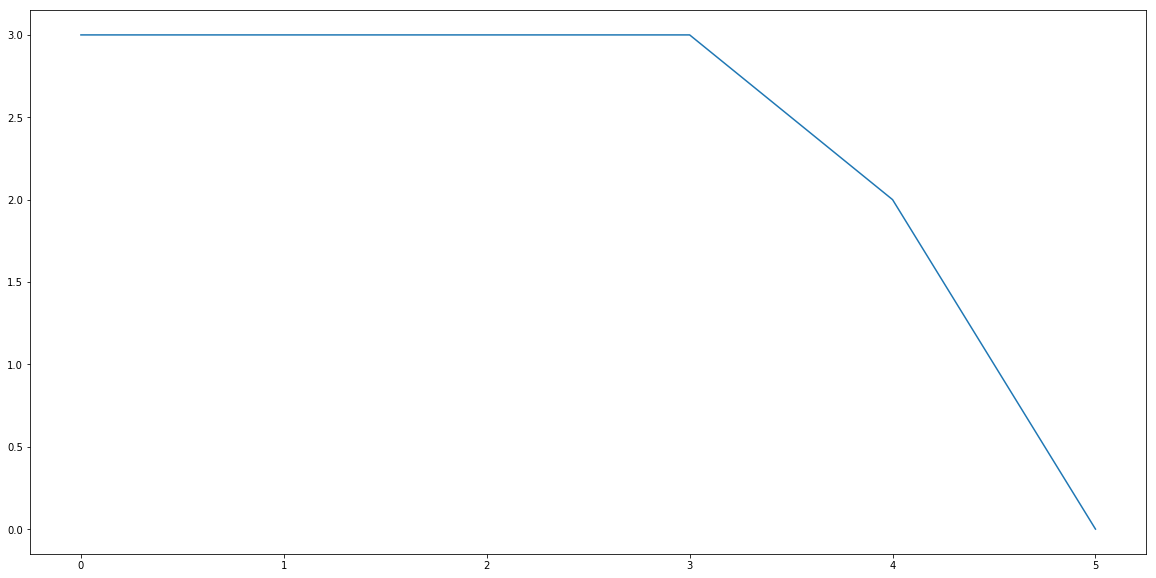

In [113]:
# Show error reduction
plt.figure(figsize=(20, 10))
plt.plot(deltas)